<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/main/predict_future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# File descriptions

itemcats_df - supplemental information about the items categories.

items_df - supplemental information about the items/products.

salestrain_df - the training set. Daily historical data from January 2013 to October 2015.

shops_df - supplemental information about the shops.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

# Imports

In [2]:
# imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
#!pip install kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [5]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         78           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        162           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        375           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2466           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      19298            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4904           False  
connectx

In [6]:
!mkdir -p predict_future_sales

In [7]:
uploaded2 = files.upload()

Saving test.csv to test.csv
Saving shops.csv to shops.csv
Saving sample_submission.csv to sample_submission.csv
Saving sales_train.csv to sales_train.csv
Saving items.csv to items.csv
Saving item_categories.csv to item_categories.csv


In [8]:
!cp test.csv predict_future_sales/
!cp item_categories.csv predict_future_sales/
!cp items.csv predict_future_sales/
!cp sales_train.csv predict_future_sales/
!cp sample_submission.csv predict_future_sales/
!cp shops.csv predict_future_sales/
!cp test.csv predict_future_sales/

# Importing All Predict Sales Data

In [9]:
#importing all the data frames
itemcats_df = pd.read_csv("predict_future_sales/item_categories.csv") #Item Categories
items_df = pd.read_csv("predict_future_sales/items.csv", encoding='unicode_escape') # Items
salestrain_df = pd.read_csv("predict_future_sales/sales_train.csv") #Sales Data - Training
shops_df = pd.read_csv("predict_future_sales/shops.csv", encoding='unicode_escape') # Shops

In [10]:
# sample submission dataframe
sample_df = pd.read_csv('predict_future_sales/sample_submission.csv')

# test data frame
test_df = pd.read_csv('predict_future_sales/test.csv')

# Data EDA

In [11]:
# creating a master list of all dataframes
df_list = [itemcats_df, items_df, salestrain_df, shops_df]

In [12]:
# creating a loop to print head, description, info, and null sum for each datafram in master list 
for df in df_list:
    print(f'DATAFRAME HEAD: {df.head()}')
    print('-----------------------')
    print(f'DATAFRAME DESCRIPTION: {df.describe()}')
    print('-----------------------')
    print(f'DATAFAME INFO: {df.info()}')
    print('-----------------------')
    print(f'DATAFRAME NULL SUM: {df.isnull().sum()}')
    print('------------------------------------------------------------------------------')

DATAFRAME HEAD:            item_category_name  item_category_id
0  PC - Headsets / Headphones                 0
1           Accessories - PS2                 1
2           Accessories - PS3                 2
3           Accessories - PS4                 3
4           Accessories - PSP                 4
-----------------------
DATAFRAME DESCRIPTION:        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
DATAFAME INFO: None
-----------------------
DATAFRAME NULL SUM: i

In [13]:
# checking itemcats_df column data types
itemcats_df.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [14]:
# checking item_df column data types
items_df.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [15]:
# checking salestrain_df data types
salestrain_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [16]:
# changing salestrain 'item_cnt_day' col from float64 -> int16
salestrain_df['item_cnt_day'] = pd.to_numeric(salestrain_df['item_cnt_day'], downcast='signed')

In [17]:
# changing salestrain 'date' col from object -> datetime
salestrain_df['date'] = pd.to_datetime(salestrain_df['date'])

In [18]:
shops_df.dtypes

shop_name    object
shop_id       int64
dtype: object

# Combine DFs

In [19]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df,on='item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df,on='item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df,on='shop_id')

In [20]:
salestrain_df_combined.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [21]:
# setting the id col, and 2 target cols based on testing data
id_col, target_col_item, target_col_shop = salestrain_df.index, salestrain_df_combined['item_id'], salestrain_df_combined['shop_id']

# Data Viz

In [22]:
# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue feature
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0


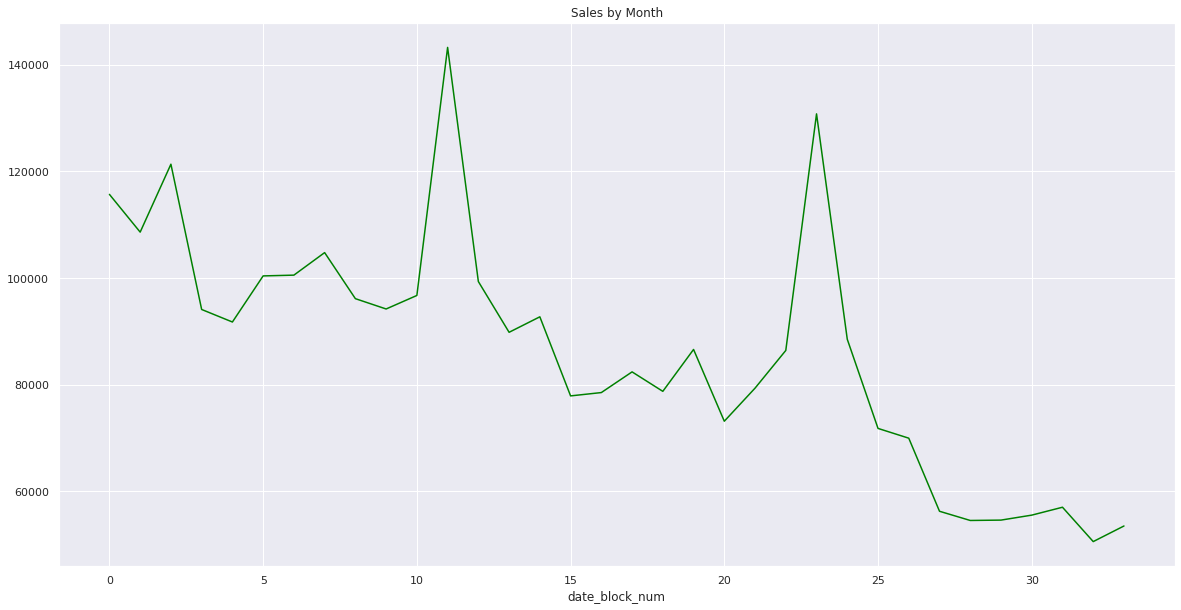

In [23]:
sns.set()
salestrain_df_combined.groupby('date_block_num').date.count().plot.line(title='Sales by Month', color='green', figsize=(20, 10))

As we can see, sales are decreasing through the years. 
We also see a spike sale during december. 
Since, the dataset is up to October, are we seeing some spike in year 2015?

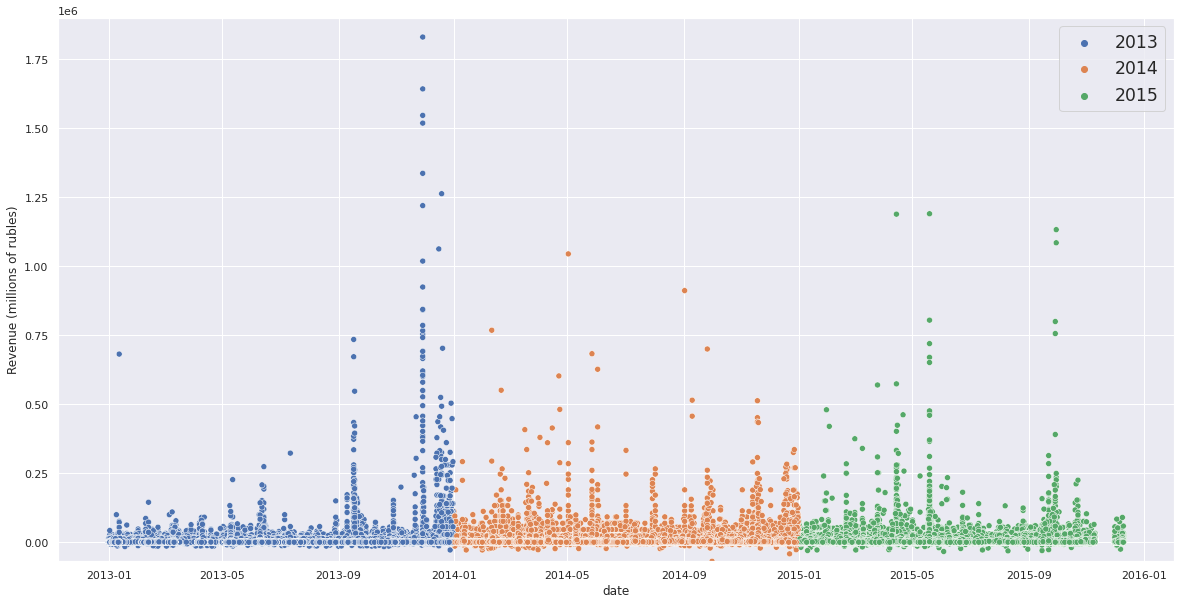

In [52]:
# time series scatterplot of revenue highlighting years
plt.figure(figsize = (20, 10))
sns.scatterplot(x = salestrain_df_combined['date'], y = salestrain_df_combined['revenue'], hue = salestrain_df_combined['year'], palette='deep')
plt.ylim(salestrain_df_combined['revenue'].min(), 1900000)
plt.annotate('test', xy=(,1829990.0000013))
#plt.axvline()
plt.ylabel('Revenue (millions of rubles)')
plt.legend(fontsize='x-large')
plt.show()

In [59]:
# printing most amount of revenue and least amount of revenue
print(f'The least amount of revenue recorded is: {salestrain_df_combined.revenue.min()}')
print(f'The most amount of revenue recorded is: {salestrain_df_combined.revenue.max()}')

The least amount of revenue recorded is: -68970.0
The most amount of revenue recorded is: 1829990.0000013


In [77]:
for row in salestrain_df_combined['revenue']:
  if int(row) == int(row).max():
    print(salestrain_df_combined['date'][row])
#salestrain_df_combined.loc[salestrain_df_combined['revenue'] == 1829990.0000013][salestrain_df_combined['date']]

AttributeError: ignored

In [41]:
salestrain_df_combined['revenue'].head(10)

0    999.0
1    150.0
2    199.5
3    199.5
4    598.0
5    299.0
6    299.0
7    299.0
8    299.0
9    199.0
Name: revenue, dtype: float64

In [47]:
# masking revenue numbers to show negative revenue
# not sure how to have negative revenue
# item returns?
salestrain_neg_mask = salestrain_df_combined['revenue'] < 0
salestrain_df_combined[salestrain_neg_mask].head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
181,2013-02-25,1,59,10308,399.00,-1,GANGSTER (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,25,-399.00
204,2013-06-20,5,59,14549,149.00,-1,The meeting place can not be changed e (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,20,-149.00
1894,2014-12-09,20,59,19089,149.00,-1,Star Trek RETRIBUTION (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,12,9,-149.00
2056,2014-05-20,16,59,11034,425.76,-1,JFK: SHOTS in Dallas (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,5,20,-425.76
2082,2013-11-18,10,59,19688,999.00,-1,Pacific Rim (2 BD) + 3D card,37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,11,18,-999.00
2472,2014-11-26,22,59,14598,499.00,-1,Million Ways HEAD (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,11,26,-499.00
2768,2013-06-28,5,59,5500,1449.00,-1,PINK FLOYD The Wall Original Recording Remaste...,56,Music - CD production firm,"Yaroslavl shopping center ""Altair""",2013,6,28,-1449.00
2993,2013-10-22,9,59,1729,299.00,-1,BOCELLI ANDREA Amore,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,10,22,-299.00
3331,2014-02-05,16,59,7299,399.00,-1,V / A Classical Beatles 2CD,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2014,2,5,-399.00
4157,2013-12-31,11,59,21565,349.00,-1,CHOI Victor Tsoi 50,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,12,31,-349.00


In [25]:
# grouping revenue by month and rounding number
monthly_group = salestrain_df_combined.groupby(by=['month'])
monthly_group_sum = monthly_group['revenue'].sum().round()      
monthly_group_sum                   

month
1     248888930.0
2     283474409.0
3     297738796.0
4     260400096.0
5     281549528.0
6     246674065.0
7     228964549.0
8     250892203.0
9     318244583.0
10    253804098.0
11    296913609.0
12    431381479.0
Name: revenue, dtype: float64

In [26]:
# normalizing data for visualization
monthly_group_norm = (monthly_group_sum - monthly_group_sum.mean()) / (monthly_group_sum.max() - monthly_group_sum.min())
monthly_group_norm = abs(monthly_group_norm)
monthly_group_norm

month
1     0.169724
2     0.001139
3     0.071609
4     0.112855
5     0.008371
6     0.180666
7     0.268156
8     0.159827
9     0.172914
10    0.145441
11    0.067533
12    0.731844
Name: revenue, dtype: float64

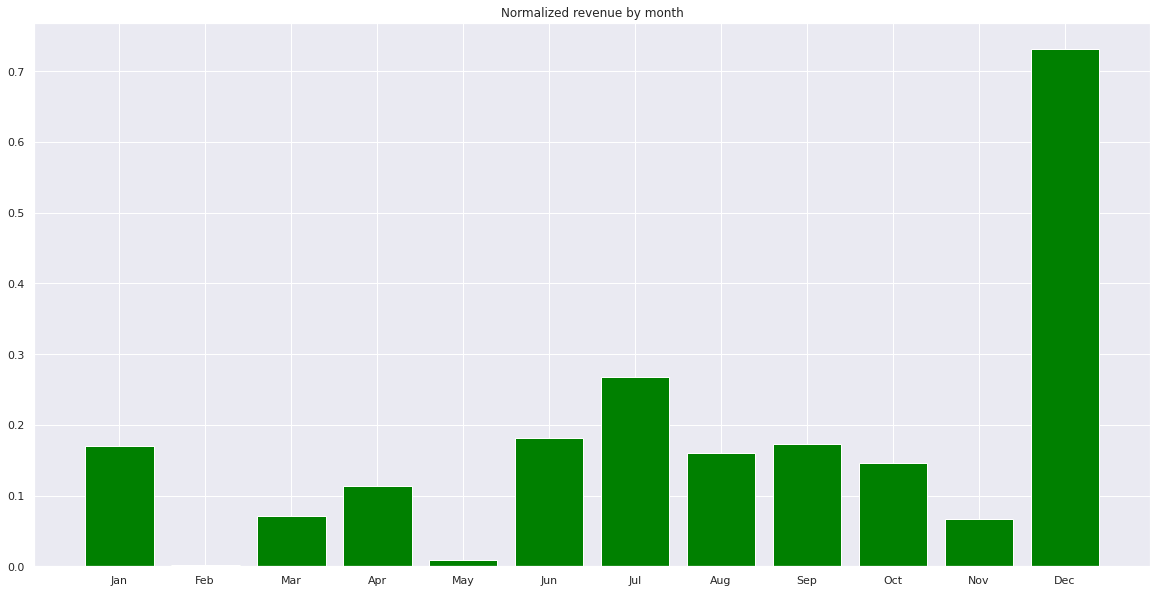

In [27]:
# graphing normalized revenue
# look at those december sales!!
ax, fig = plt.subplots(figsize=(20,10))
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(cols, monthly_group_norm, color='red')
plt.title('Normalized revenue by month')
plt.show()

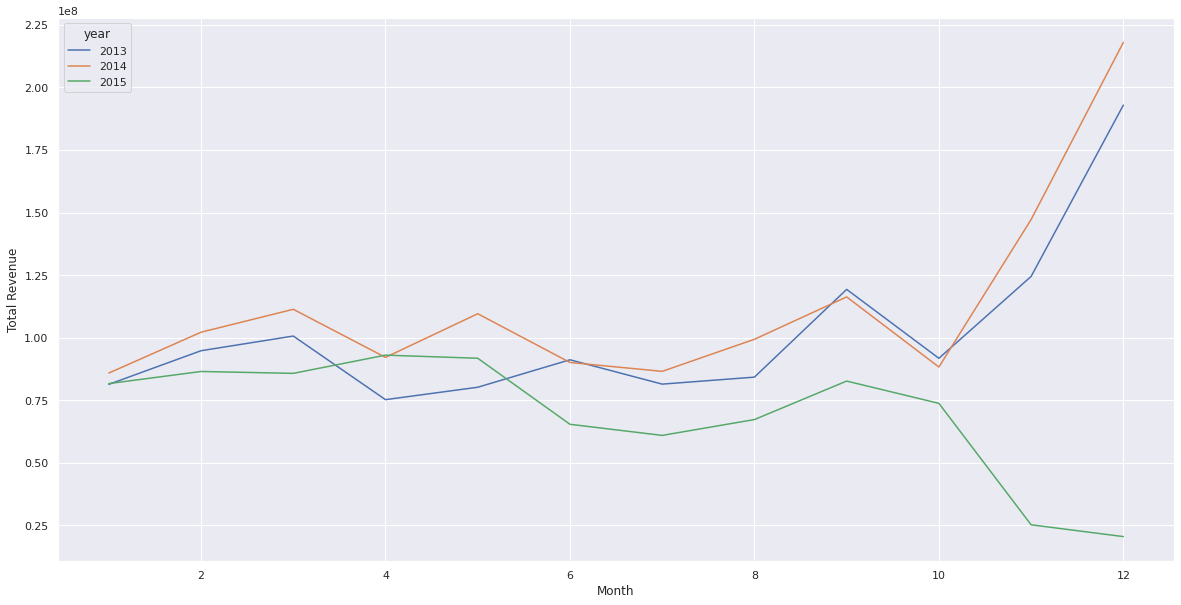

In [28]:
# Plot total revenue by month for each year
salestrain_df_combined.groupby(['month', 'year']).sum()['revenue'].unstack().plot(figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

There are no sales spike on december 2015.

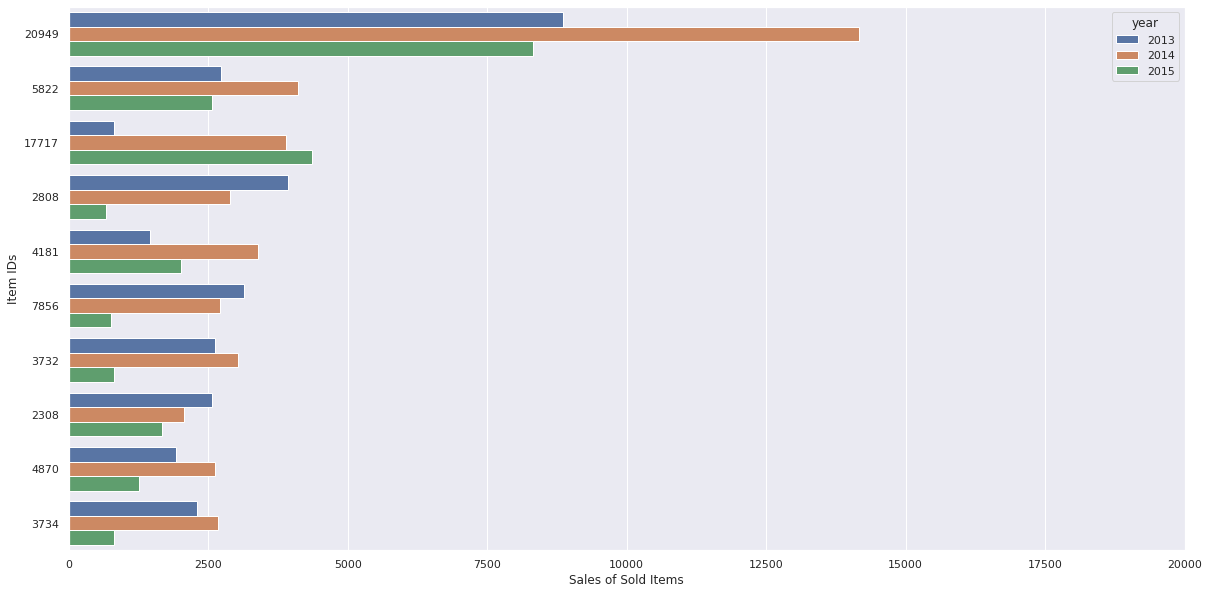

In [29]:
# Plot the top 10 most items sold
plt.figure(figsize = (20, 10))
sns.countplot(y = 'item_id', hue = 'year', data = salestrain_df_combined, order = salestrain_df_combined['item_id'].value_counts().iloc[:10].index)
plt.xlim(0, 20000)
plt.xlabel('Sales of Sold Items')
plt.ylabel('Item IDs')
plt.show()

In [30]:
salestrain_df_combined.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0
5,2013-10-21,9,59,944,299.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,10,21,299.0
6,2013-02-11,10,59,944,299.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,11,299.0
7,2014-06-01,12,59,944,299.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,6,1,299.0
8,2014-03-30,14,59,944,299.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,3,30,299.0
9,2014-04-20,15,59,944,199.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,4,20,199.0


In [31]:
salestrain_df_combined.value_counts()[10:]
#for item in salestrain_df_combined['item_id'].unique():
 # print(item)

date        date_block_num  shop_id  item_id  item_price  item_cnt_day  item_name                                                           item_category_id  item_category_name           shop_name                      year  month  day  revenue 
2013-10-13  9               54       19415    649.0       -1            Sniper. Ghost Warrior 2 [PC, Jewel, Russian version]                30                Games PC - Standard Edition  Khimki shopping center "Mega"  2013  10     13   -649.0      1
                                     19404    1799.0       1            The Smurfs 2 [X360, English version]                                23                Games - XBOX 360             Khimki shopping center "Mega"  2013  10     13    1799.0     1
                                     19094    1199.0       1            Star Trek: RETRIBUTION (+ Star Trek) (BD)                           37                Movie - Blu-Ray              Khimki shopping center "Mega"  2013  10     13    1199.0     1
     

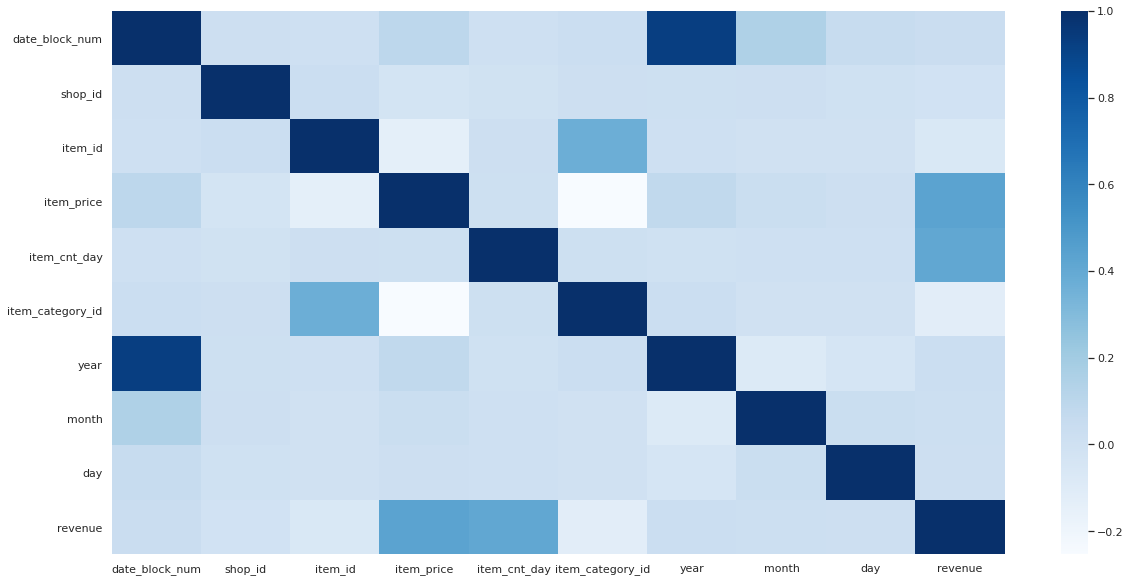

In [32]:
plt.figure(figsize = (20, 10))
sns.heatmap(salestrain_df_combined.corr(), cmap='Blues')
plt.show()

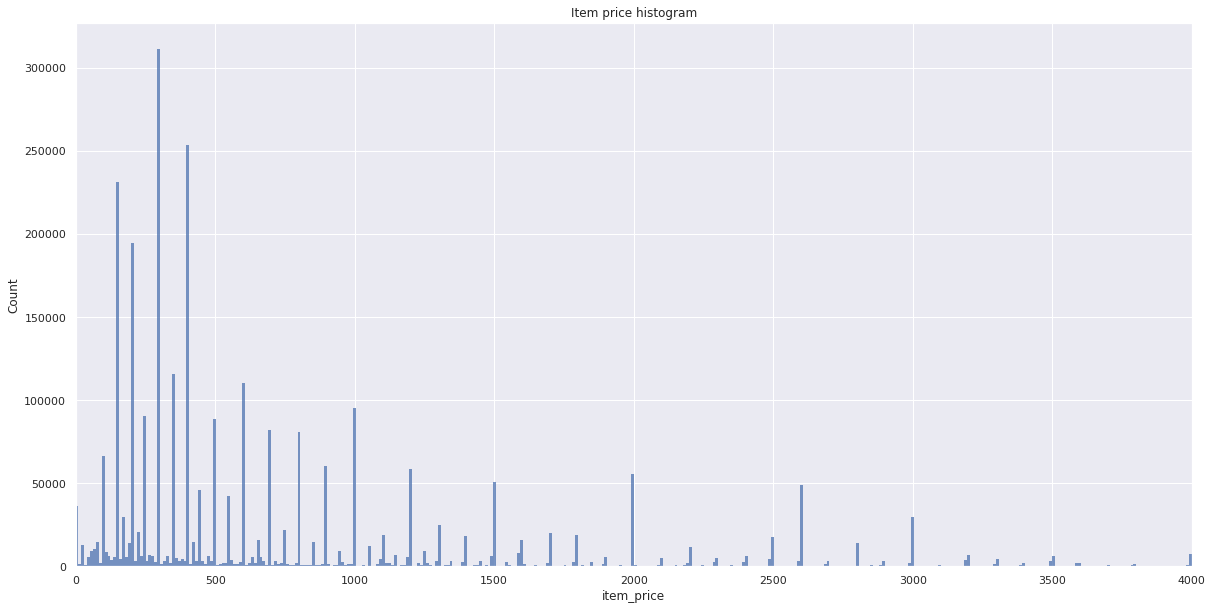

In [33]:
# plotting histogram of the price of items
# some high ticket items, lots 
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='item_price', data=salestrain_df)
plt.xlim(0, 4000)
plt.title('Item price histogram')
plt.show()

create item price bands to graph

whisker plot with yearly revenue?

pair plot variation? diag_kind='hist'

sns.scatterplot

In [34]:
salestrain_df_combined['revenue'].head(10)

0    999.0
1    150.0
2    199.5
3    199.5
4    598.0
5    299.0
6    299.0
7    299.0
8    299.0
9    199.0
Name: revenue, dtype: float64

In [35]:
len(salestrain_df_combined['revenue'])

2935849

In [36]:
len(salestrain_df_combined['date'])

2935849

In [37]:
x = salestrain_df_combined['date']
y = salestrain_df_combined['r']

KeyError: ignored

In [ ]:
salestrain_df_combined.columns